# 📊 Pandas Time Series — Master Notebook
Este cuaderno contiene explicaciones resumidas, ejemplos y ejercicios resueltos sobre manejo de series temporales en Pandas: DateTimeIndex, resampling, shifting, rolling/expanding y bandas de Bollinger.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

# Generador reproducible
rng = np.random.default_rng(7)

# Si no tienes el dataset de Walmart, se sintetiza uno para que el notebook sea ejecutable.
def load_walmart():
    dates = pd.date_range("2012-01-03", periods=1250, freq="B")  # ~5 años
    price = 60 + np.cumsum(rng.normal(0, 0.3, len(dates)))
    high = price + rng.normal(0.2, 0.15, len(dates)).clip(min=0)
    low  = price - rng.normal(0.2, 0.15, len(dates)).clip(min=0)
    open_ = price + rng.normal(0, 0.15, len(dates))
    volume = rng.integers(2_000_000, 6_000_000, len(dates))

    return pd.DataFrame({
        "Open": open_, "High": high, "Low": low, "Close": price,
        "Volume": volume, "Adj Close": price
    }, index=dates)

WMT = load_walmart()
WMT.head()


,Open,High,Low,Close,Volume,Adj Close
2012-01-03,60.084728,60.099031,59.830103,60.000369,2136181,60.000369
2012-01-04,60.017766,60.221506,60.022568,60.089993,4411938,60.089993
2012-01-05,60.065286,60.060121,59.492720,60.007751,5466743,60.007751
2012-01-06,59.911491,59.970375,59.465921,59.740574,3804173,59.740574
2012-01-09,59.548350,59.983003,59.604173,59.604173,2829085,59.604173


## 1) Datetime y DatetimeIndex
Python ofrece el módulo `datetime`. Pandas puede convertir listas de datetime en índices especiales.

In [2]:
from datetime import datetime

my_dt = datetime(2017, 1, 2, 13, 30, 15)
print(my_dt, "| type:", type(my_dt))
print("Year:", my_dt.year, "Month:", my_dt.month, "Day:", my_dt.day)

# Crear DatetimeIndex
dt_index = pd.DatetimeIndex([datetime(2016,1,1), datetime(2016,1,2)])
df = pd.DataFrame(np.random.randn(2,2), index=dt_index, columns=["A","B"])
df


2017-01-02 13:30:15 | type: <class 'datetime.datetime'>
Year: 2017 Month: 1 Day: 2


,A,B
2016-01-01,0.291635,0.175788
2016-01-02,2.194803,1.183424


## 2) Resampling
Permite reagrupar por frecuencia de tiempo, similar a `groupby`. Ejemplo:

/var/folders/40/qq7n2_gd71l5n9hlkzt509b00000gn/T/ipykernel_98835/2541949513.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_mean = WMT['Close'].resample("A").mean()


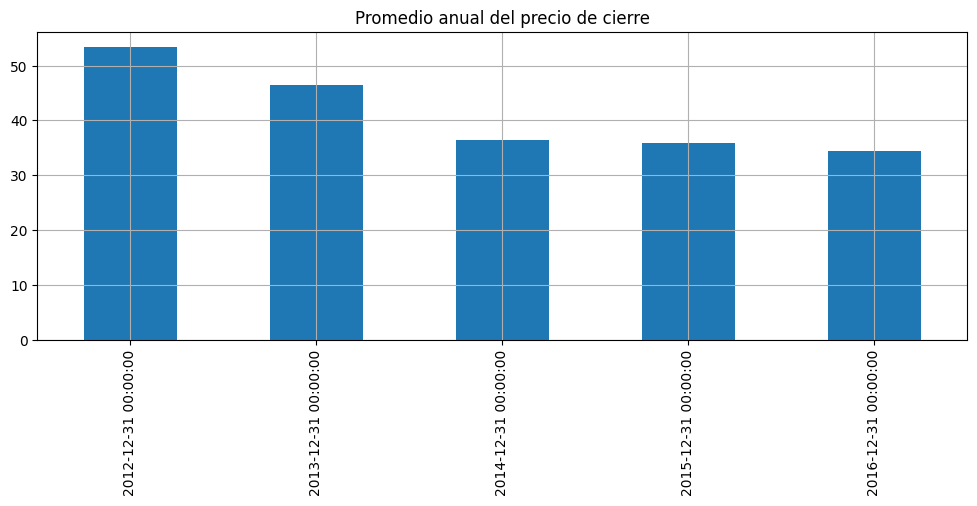

In [3]:
# Promedio anual del cierre
annual_mean = WMT['Close'].resample("A").mean()
annual_mean.plot(kind="bar", title="Promedio anual del precio de cierre");


## 3) Shifting
Desplaza datos hacia adelante o atrás en el tiempo.

In [4]:
shifted = WMT.shift(periods=1)
pd.concat([WMT['Close'].head(3), shifted['Close'].head(3)], axis=1).rename(
    columns={"Close":"Original","Close":"Shifted"}
)


,Shifted,Shifted
2012-01-03,60.000369,NaN
2012-01-04,60.089993,60.000369
2012-01-05,60.007751,60.089993


## 4) Rolling & Expanding
Rolling calcula medias móviles, expanding calcula promedio acumulado desde el inicio.

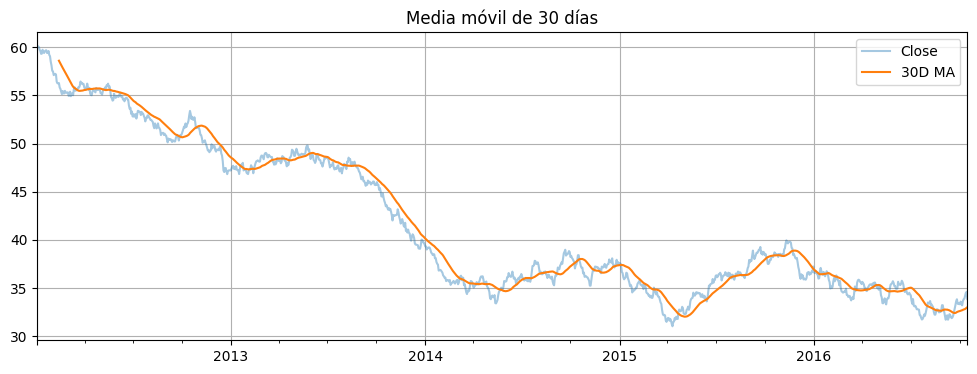

In [5]:
ax = WMT['Close'].plot(alpha=0.4, label="Close")
WMT['Close'].rolling(window=30).mean().plot(ax=ax, label="30D MA")
plt.legend()
plt.title("Media móvil de 30 días");


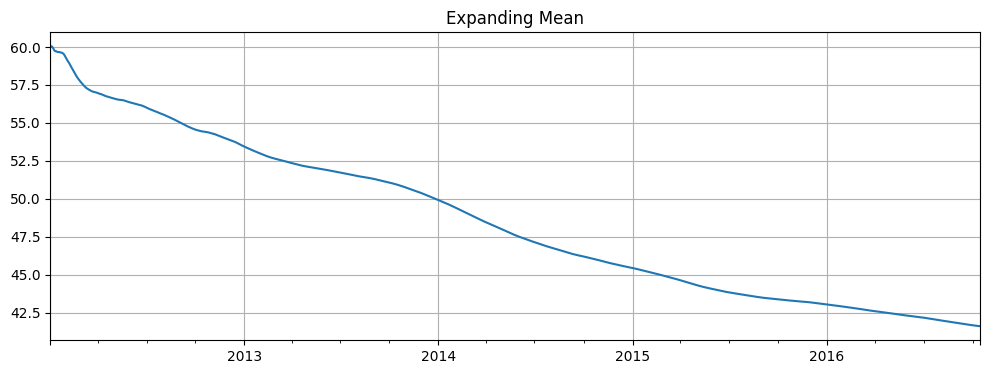

In [6]:
# Expanding mean
WMT['Close'].expanding(min_periods=1).mean().plot(title="Expanding Mean");


## 5) Bollinger Bands
Indicador técnico: banda superior e inferior = media ± 2*desviación estándar.

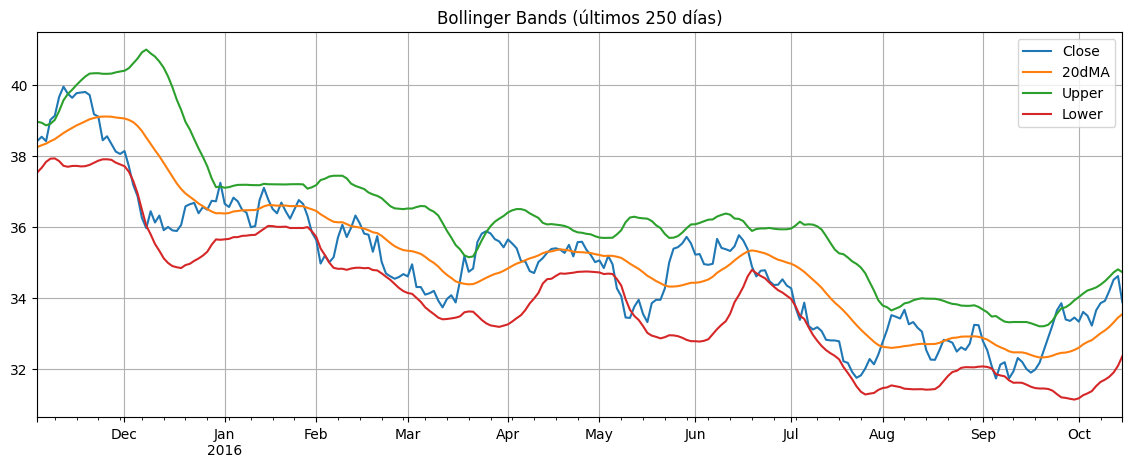

In [7]:
df = WMT.copy()
df['20dMA'] = df['Close'].rolling(window=20).mean()
df['Upper'] = df['20dMA'] + 2*df['Close'].rolling(window=20).std()
df['Lower'] = df['20dMA'] - 2*df['Close'].rolling(window=20).std()

df[['Close','20dMA','Upper','Lower']].tail(250).plot(figsize=(14,5),
    title="Bollinger Bands (últimos 250 días)");
